# K-means for color compression

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn datasets module.

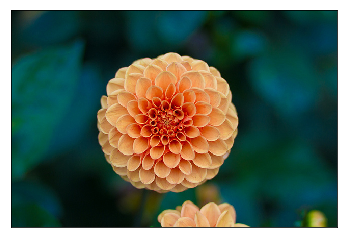

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_images
dataset = load_sample_images()
image = dataset.images[1]
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(image);

In [161]:
size = image.shape
size

(427, 640, 3)

Let's figure out the number of the colours that are present in the image - the whole RGB space has cardinality of *~16,7 millions*, our image size is also the upper bound for the number of colour (that is number of unique colours <= the number of pixels: *273280*). 

For that, we create the dictionary of the RGB values:

In [131]:
img_dict = {}
### takes some seconds to run
for x in range(size[0]):
    for y in range(size[1]):
        r,g,b = image[x,y,:]
        # key for the dictionary is the color
        if (r,g,b) in img_dict.keys():
            img_dict[(r,g,b)]+=1
        else:
            img_dict[(r,g,b)] = 1

In [132]:
colours = img_dict.keys()

Number of unique colours in the image is:

In [133]:
len(colours)

62941

To compare with actual image size (total number of pixels):

In [134]:
size[0]*size[1], len(colours)/(size[0]*size[1])

(273280, 0.23031689110070258)

Put RGB values in the dataframe for easier use:

In [135]:
import pandas
df = pandas.DataFrame(colours)
df.columns = ['R', 'G','B']
df.head(3)

,R,G,B
0,2,19,13
1,3,18,13
2,7,20,13


### Colour histogram

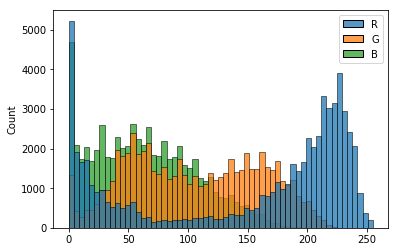

In [136]:
import seaborn as sns
sns.histplot(df)

### Number histogram of RGB:

In [166]:
rgb_df = img_dict.values()

Plotting how many times same colours are repeated: as we might observe, majority of the RGB values are actually unique (~39k).

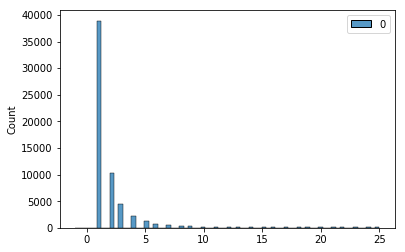

In [184]:
sns.histplot(rgb_df, bins = 70, binrange = [-1, 25])

### Coming back to k-means

First we normalize the image array

In [137]:
data = image / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [138]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

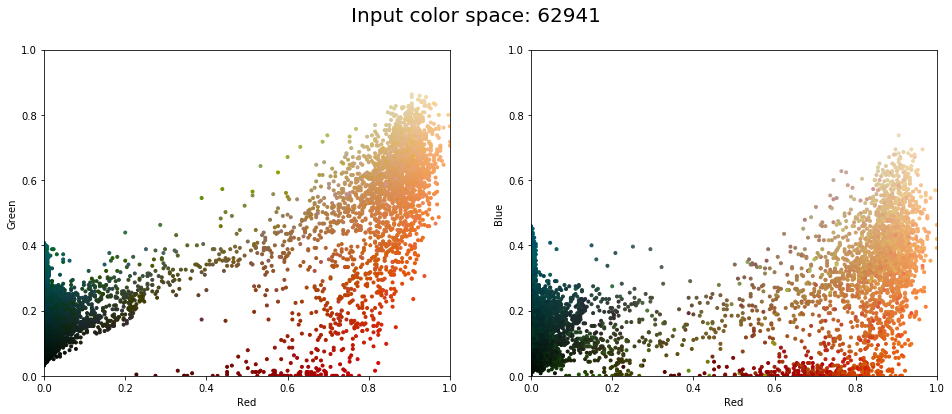

In [139]:
plot_pixels(data, title='Input color space: 62941')

Now let's reduce these 62941 colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

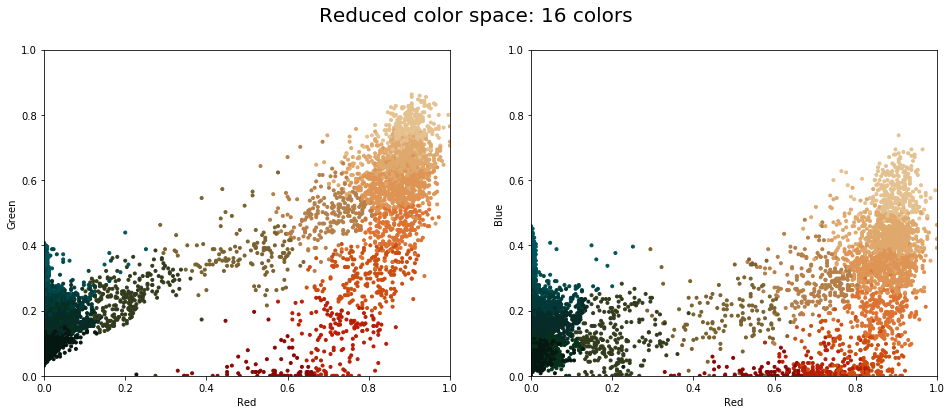

In [179]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")
### we can actually see the clusters that are coloured respectively with a bit of zooming!
### Nice!

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

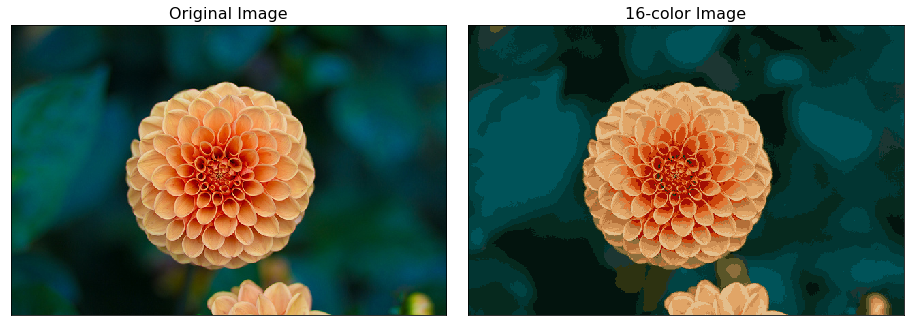

In [141]:
image_recolored = new_colors.reshape(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(image_recolored)
ax[1].set_title('16-color Image', size=16);

## A bit bigger image to see 16 clusters:

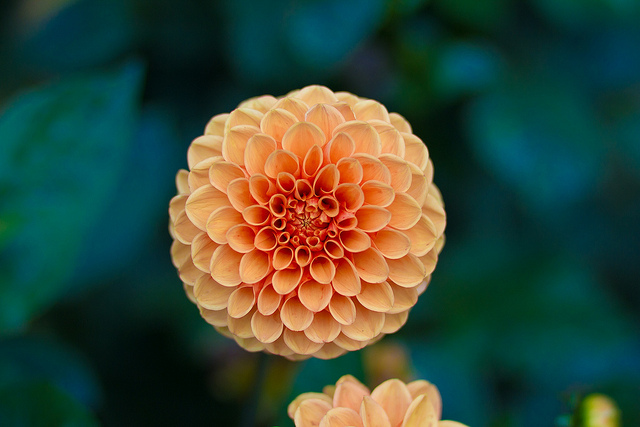

In [142]:
from PIL import Image
Image.fromarray(image)

In [157]:
### coming back to the space before scaling
image_recolored = np.round(image_recolored * 255)

In [181]:
### and putting the image_recolored array to 'uint8' so that datatype would match for PIL library:
image_recolored = image_recolored.astype('uint8')

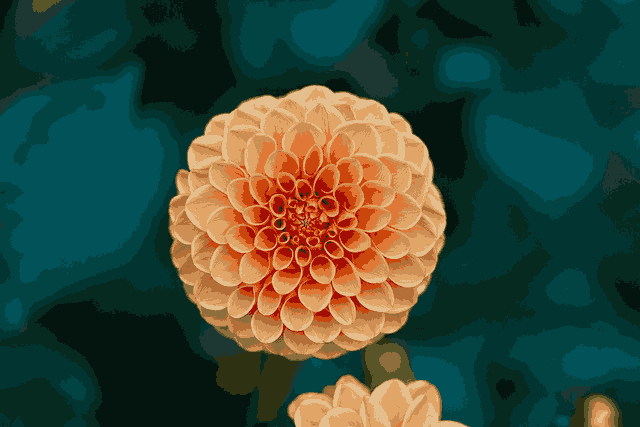

In [182]:
Image.fromarray(image_recolored)

### References:

1. Jake VanderPlas. 2016. Python Data Science Handbook: Essential Tools for Working with Data (1st. ed.). O'Reilly Media, Inc.
2. Waskom, M., Botvinnik,                 Olga, O&#x27;Kane,                 Drew, Hobson,                 Paul, Lukauskas,                 Saulius, Gemperline,                 David C, … Qalieh,                 Adel. (2017). mwaskom/seaborn: v0.8.1 (September 2017). Zenodo. https://doi.org/10.5281/zenodo.883859
3. Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830.